In [1]:


import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from torch import optim
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import SequentialSampler

from bank_telemarketing.config import config
from bank_telemarketing.features.build_features import CustomDataset
from bank_telemarketing.models.models import Classifier
from bank_telemarketing.preprocessing.embedding import CategoricalEmbeddingSizes
from bank_telemarketing.preprocessing.preprocess import CustomScaler
from bank_telemarketing.preprocessing.preprocess import MultiLabelEncoder

## I - Data preprocessing

### I.1 - Import data

In [2]:
data = pd.read_csv("../data/clean/clean_bank_full.csv")

### I.2 define columns

In [3]:
x_emb_cols = ["job", "marital", "education", "default", "housing", "loan", "month", "day_of_week", "poutcome"]

x_bin_col = ["contact", "has_been_contacted"]

y_col = "subscribed"

x_numerical = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx",
               "euribor3m", "nr.employed"]

cats = x_emb_cols + x_bin_col
all_cols = x_emb_cols + x_bin_col + x_numerical

In [4]:
# set columns categories types
data[cats] = data[cats].astype("category")

### I-3 Apply preprocessing pipeline

In [5]:
x_pipe = Pipeline(
    steps=
    [
        ("label_encoder", MultiLabelEncoder(cols=cats)),
        ("scaler", CustomScaler(cols=x_numerical))
    ]
)

y_mapping = {"no": 0, "yes": 1}

In [6]:
y = data.subscribed
X = data.drop(["subscribed", "duration"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

### I.4 - Create train and test batch data (tensor) for the training

In [8]:
# Train data
y_train = y_train.replace(y_mapping).reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_train = x_pipe.fit_transform(X_train)
train_dataset = CustomDataset(
    emb_cols=x_emb_cols,
    x=X_train,
    y=y_train
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=config["TRAIN_BS"]
)

In [9]:
# Validation data
y_test = y_test.replace(y_mapping).reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test = x_pipe.transform(X_test)
test_dataset = CustomDataset(
    emb_cols=x_emb_cols,
    x=X_test,
    y=y_test
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=config["VALID_BS"]
)

### I.5 - Get categorical embedding parameters

In [10]:
# Get embedding size
emb = CategoricalEmbeddingSizes().get_cat_emb_dims(data=X_train, cat_cols=cats)[0]

## II - Modeling

### II.1 - Instantiate model

In [11]:
model = Classifier(
    hidden=64,
    output_size=1,
    continuous_size=11,
    embedding_sizes=emb,
    dropout=0.3
)
model.to(config["DEVICE"])
model.train()

Classifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layers): ModuleList(
    (0): Embedding(13, 7)
    (1): Embedding(5, 3)
    (2): Embedding(9, 5)
    (3): Embedding(4, 2)
    (4): Embedding(4, 2)
    (5): Embedding(4, 2)
    (6): Embedding(11, 6)
    (7): Embedding(6, 3)
    (8): Embedding(4, 2)
  )
  (linear): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=config["LR"])
cyclic_optimizer = optim.SGD(model.parameters(), lr=config["LR"], momentum=0.9)

pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

criterion = BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
criterion.to(config["DEVICE"])

BCEWithLogitsLoss()

In [13]:
from torch.optim import lr_scheduler

linear_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=10,
)

cyclic_scheduler = lr_scheduler.CyclicLR(
    optimizer=cyclic_optimizer,
    base_lr=config["LR"],
    max_lr=0.1,
)

## III Training

In [16]:
from bank_telemarketing.train.engine import engine

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    engine(
        model=model,
        criterion=criterion,
        optimizer=cyclic_optimizer,
        train_dataloader=train_dataloader,
        eval_dataloader=test_dataloader,
        config=config,
        scheduler=cyclic_scheduler,
        pos_weight=pos_weight,
        logs_dir="../logs",
        checkpoint_dir="../models_storage"
    )

======================= Training Started ============================
Epoch: 1    | Elapsed Time:  10.24 s | Train Loss:  0.0435 | Valid Loss:  0.0031 | Train F1:  0.4495 | Valid F1:  0.4238 | Train Precision:  0.3449 | Valid Precision:  0.2990 |  + 
Epoch: 2    | Elapsed Time:  12.63 s | Train Loss:  0.0436 | Valid Loss:  0.0031 | Train F1:  0.4502 | Valid F1:  0.4676 | Train Precision:  0.3440 | Valid Precision:  0.3579 |  + 
Epoch: 3    | Elapsed Time:  14.34 s | Train Loss:  0.0433 | Valid Loss:  0.0031 | Train F1:  0.4514 | Valid F1:  0.4757 | Train Precision:  0.3485 | Valid Precision:  0.3690 |  + 
Epoch: 4    | Elapsed Time:  14.16 s | Train Loss:  0.0434 | Valid Loss:  0.0031 | Train F1:  0.4527 | Valid F1:  0.4667 | Train Precision:  0.3470 | Valid Precision:  0.3551 | 
Epoch: 5    | Elapsed Time:  12.23 s | Train Loss:  0.0435 | Valid Loss:  0.0031 | Train F1:  0.4490 | Valid F1:  0.4787 | Train Precision:  0.3438 | Valid Precision:  0.3736 |  + 
Epoch: 6    | Elapsed Time: 

In [24]:
import os

checkpoint = torch.load(os.path.join("../models_storage", "checkpoint-04484096198603569.pt"))

In [26]:
state_dict = checkpoint["best_state_dict"]
m = Classifier(
    hidden=64,
    output_size=1,
    continuous_size=11,
    embedding_sizes=emb,
    dropout=0.3
)

m.load_state_dict(state_dict)
m.to("cuda")

Classifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layers): ModuleList(
    (0): Embedding(13, 7)
    (1): Embedding(5, 3)
    (2): Embedding(9, 5)
    (3): Embedding(4, 2)
    (4): Embedding(4, 2)
    (5): Embedding(4, 2)
    (6): Embedding(11, 6)
    (7): Embedding(6, 3)
    (8): Embedding(4, 2)
  )
  (linear): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [44]:
from typing import List


def predict(model, x_cont, x_emb, cut_point: float, device: str = "cpu") -> (List[float], List[float]):
    model.eval()

    with torch.no_grad():
        x_emb = x_emb.to(device)
        x_cont = x_cont.to(device)

        logits = model(x_cont, x_emb).squeeze(1)

        prob = torch.sigmoid(logits).detach().tolist()
        y_pred = [p >= cut_point for p in prob]
    return prob, y_pred

In [47]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=200
)

In [43]:
for batch in test_dataloader:
    x_cont = batch["x_cont"]
    x_emb = batch["x_emb"]
    y = batch["y"]

    prob, pred = predict(
        model=m,
        x_cont=x_cont,
        x_emb=x_emb,
        cut_point=0.5,
        device="cuda"
    )

    print(f"Prob: {prob}")
    print(f"Prediction: {pred}")
    print(f"True label: {y}")
    break

[0.17705123126506805, 0.1394490897655487, 0.5402640104293823]
Prob: [0.17705123126506805, 0.1394490897655487, 0.5402640104293823]
Prediction: [False, False, True]
True label: tensor([0, 0, 0])


In [66]:


from sklearn.metrics import accuracy_score
from bank_telemarketing.utils import model_performance


def evaluate(model, dataloader, device, pos_weight, cut_point=0.5):
    y_trues = []
    losses = []
    probs = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            x_emb = batch["x_emb"].to(device)
            x_cont = batch["x_cont"].to(device)
            y_true = batch["y"].to(device)

            logits = model(x_cont, x_emb)
            logits = logits.squeeze(1)

            loss = criterion(logits, y_true.float())

            losses.append(loss.detach().cpu().item() * len(batch))
            probs.extend(torch.sigmoid(logits).detach().tolist())
            y_trues.extend(y_true.detach().cpu().tolist())

        y_preds = [p >= cut_point for p in probs]
        acc = accuracy_score(y_pred=y_preds, y_true=y_trues)
        # print(len(y_true))
        # print(len(y_preds))

        train_performance = model_performance(
            y_true=y_trues,
            y_pred=y_preds,
            losses=losses,
            pos_weight=pos_weight,
        )
        return train_performance, acc, y_preds, y_trues

In [67]:
perf = evaluate(
    model=m,
    dataloader=test_dataloader,
    device="cuda",
    cut_point=0.5,
    pos_weight=pos_weight
)

In [68]:
perf

({'loss': 0.015003011115492404,
  'f1': 0.5179211469534051,
  'precision': 0.4484096198603569},
 0.8693540553666829,
 [False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  

<AxesSubplot:>

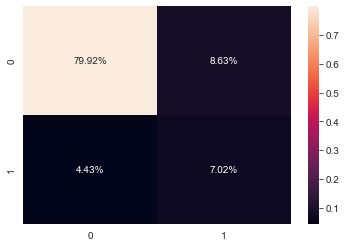

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true=perf[3], y_pred=perf[2])
sns.heatmap(cm / np.sum(cm), annot=True, fmt=".2%")